In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d

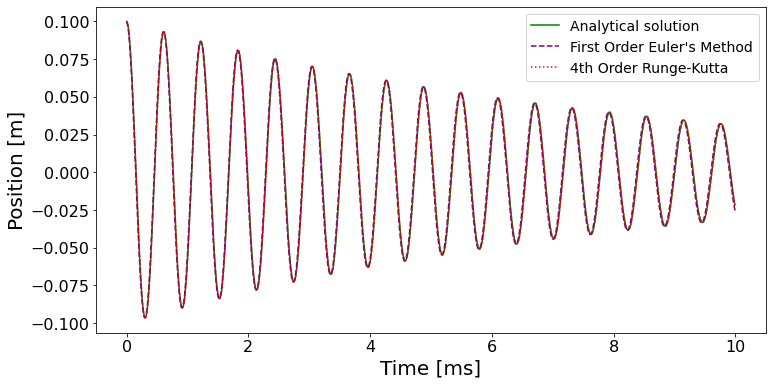

In [2]:
import nbimporter
%run DampedOscillator.ipynb

# 2D MOT Simulation

In [235]:
# Physical Constants
hbar = 1.055 * 10**(-34) # Js, reduced Planck's constant
light_c = 2.998 * 10**(8) # m/s
BohrMag = 9.27401008 * 10**(-24) # A m^2

# Rubidium-87 Specifics
mass_Rb87 = 1.4431609 * 10**(-25) # kg
gamma = 6.06 * 10**(6) # Hz, natural line width (FWHM of D2 transition of Rb-87). Szulc.
omega_D2 = 2*np.pi* 384.2304844685 * 10**(12) # Hz. Steck.

# Apparatus
tube_diam = 2 * 10**(-3) # meters, differential pumping tube diameter
tube_length = 3 * 10**(-2) # meters, differential pumping tube length
bgrad_x = 0.11 # T/m, equal to 11 G/cm.
bgrad_y = bgrad_x

# Cell dimensions
x_len = 0.04 # m
y_len = 0.04 # m
z_len = 0.1  #m

# Beams
cooling_waist = 50 * 10**(-3) # m. Page 54 of Szulc uses elliptical profile. I use circular cross section.
push_waist = 9 * 10**(-3) # m. Page 54 Szulc.

# Optimize
s0 = 12 #12 # Optimal = 12.
det_x = -5.5*gamma # Optimal = -1.5gamma
det_y = -5.5*gamma # Optimal = -1.5gamma

## Implementation Info
#### Storage
Positions and velocities of particles are stored as a numpy array of length 3. All functions take in a parameter called axis which must specify "x", "y", or "z". 

#### Geometry
Cooling should occur in the xy plane. 

## Forces

The radiative force takes the form of the following with $e^{-2r^2/w^2}$ representing its Gaussian profile.
$$ \vec{F}_{\pm} =s_0 e^{-2r^2/w^2}\frac{\hbar \gamma/2}{1 + s_0e^{-2r^2/w^2} + (2\Delta_{\pm}/\gamma)^2}\cdot\frac{\omega_{D2} + \delta}{c}\hat{k}_{\pm} $$
where for the x-axis, for example:
$$ \Delta_{\pm} = \delta \mp kv_x \mp \text{sign}(x)\frac{|\tilde{\mu}B(x)|}{2\pi\hbar}$$
where $\tilde{\mu} = \frac{2}{3}\mu_B$ for the D2 line of Rb-87, and $B(x) = bx$, $b>0$.

# 1D MOT: Damping Demonstration

In [236]:
def getDeltaPM(x, v, det, bgrad):
    term1 = det
    term2 = ((omega_D2 + det)/(light_c))*v 
    #print("DeltaPM sees 2) v", v, " term2: ", term2)
    term3 = np.sign(x)*np.abs((2/3)*BohrMag*bgrad*x)/(2*np.pi*hbar)
    #print("term3: ", term3)
    Delta_plus = term1 - term2 - term3
    Delta_minus = term1 + term2 + term3
    #print("Delta_plus = ", Delta_plus)
    #print("Delta_minus = ", Delta_minus)
    return Delta_plus, Delta_minus

# Helper function for radiative force.
def radiativeHelper(Delta_plus, Delta_minus, det, s_adjusted):
    k = (omega_D2 + det)/(light_c)
    F_plus = k * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_plus/gamma)**2)
    F_minus = k * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_minus/gamma)**2)
    return F_plus - F_minus

In [237]:
def forceRadiative_x(x0, v0, axis=0):    
    # Check axis:
    det = np.NaN
    bgrad = np.NaN
    r_squared = np.NaN
    if axis == 0:
        det = det_x
        bgrad = bgrad_x
    elif axis == 1:
        det = det_y
        bgrad = bgrad_y
    elif axis == 2:
        print("do nothing") 
    
    # Compute Delta_{pm}
    Delta_plus, Delta_minus = getDeltaPM(x0, v0, det, bgrad)
    
    # Compute s_adjusted, which is s0 * e^{-2r^2/w^2}
    r_squared = 0 # FOR NOW, NO BEAM WAIST
    s_adjusted = s0 * np.exp(-2*r_squared/(cooling_waist**2))
    
    # Compute Force
    force = radiativeHelper(Delta_plus, Delta_minus, det, s_adjusted)
    
    return force

def runEuler_x(x0, v0, m=mass_Rb87, dt=10 * 10**(-6), num_timesteps=1000, axis=0):
    # Initialize state:
    xn = x0
    vn = v0

    # Data storage
    positions = []
    positions.append(xn)  # Store x0
    velocities = []
    velocities.append(vn) # Store v0
    times = []
    times.append(0)
    forces = []
    forces.append(0)
    

    # Euler Loop
    for j in range(0, num_timesteps):
        force = forceRadiative_x(xn, vn, axis=axis)
        forces.append(force)
        vdot = force/m
        print("4) vdot", vdot)
        vn = vn + dt*vdot
        #print("5) vn", vn)
        xn = xn + dt*vn

        # Update storage
        positions.append(xn)
        velocities.append(vn)
        times.append((j+1)*dt)
     
    return np.array(times), np.array(positions), np.array(velocities), np.array(forces)

4) vdot -1541.5221150951893
4) vdot -1516.225952902688
4) vdot -1491.5116705452178
4) vdot -1467.3584470837475
4) vdot -1443.7465147569749
4) vdot -1420.6570919104677
4) vdot -1398.0723210045328
4) vdot -1375.9752112568747
4) vdot -1354.349585519915
4) vdot -1333.1800310317583
4) vdot -1312.4518537145361
4) vdot -1292.1510357249726
4) vdot -1272.264195989791
4) vdot -1252.7785534834406
4) vdot -1233.6818930279471
4) vdot -1214.9625334146826
4) vdot -1196.6092976658629
4) vdot -1178.6114852697478
4) vdot -1160.9588462381398
4) vdot -1143.6415568478878
4) vdot -1126.650196940057
4) vdot -1109.975728661099
4) vdot -1093.6094765401403
4) vdot -1077.5431088052978
4) vdot -1061.7686198499232
4) vdot -1046.2783137669646
4) vdot -1031.064788876209
4) vdot -1016.1209231751864
4) vdot -1001.4398606500083
4) vdot -987.0149983873663
4) vdot -972.8399744334973
4) vdot -958.9086563500697
4) vdot -945.2151304207663
4) vdot -931.7536914657803
4) vdot -918.5188332246762
4) vdot -905.5052392709524
4) vd

Text(0, 0.5, 'F (N)')

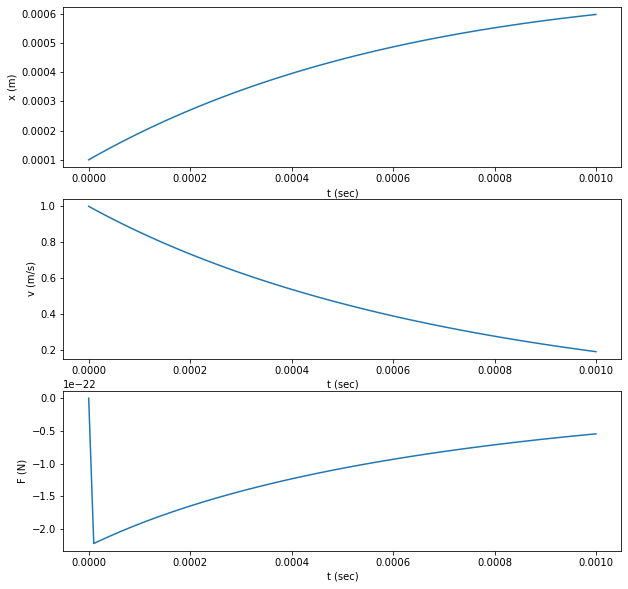

In [238]:
# Radiative force should caused damped harmonic oscillato for small x_0, small v_x.
# Testing:
num_time = 100

# Initialize an atom with these velocities
x0 = 10**(-4)
y0 = 0 # 10**(-7)
z0 = 0 # -z_len/8 # Release near bottom of cell

vx = 1 # m/s
vy = 2
vz = 3

tt, xx, vv, ff = runEuler_x(x0, vx, num_timesteps=num_time)

# positions
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].plot(tt, xx)
ax[0].set_xlabel("t (sec)")
ax[0].set_ylabel("x (m)")

ax[1].plot(tt, vv)
ax[1].set_xlabel("t (sec)")
ax[1].set_ylabel("v (m/s)")

ax[2].plot(tt, ff)
ax[2].set_xlabel("t (sec)")
ax[2].set_ylabel("F (N)")

## Preliminary Tests: 2D MOT

In [199]:
def forceRadiative(vec_x, vec_v, axis):    
    # Check axis:
    det = np.NaN
    bgrad = np.NaN
    r_squared = np.NaN
    if axis == 0:
        det = det_x
        bgrad = bgrad_x
        r_squared = vec_x[1]**2 + vec_x[2]**2
    elif axis == 1:
        det = det_y
        bgrad = bgrad_y
        r_squared = vec_x[0]**2 + vec_x[2]**2
    elif axis == 2:
        print("do nothing") 
    
    # Pull out relevant position, velocity:
    x = vec_x[axis]
    v = vec_v[axis]
    print("ForceRad extracts 1) v", v)
    
    # Compute Delta_{pm}
    Delta_plus, Delta_minus = getDeltaPM(x, v, det, bgrad)
    
    # Compute s_adjusted, which is s0 * e^{-2r^2/w^2}
    r_squared = 0 # FOR NOW, NO BEAM WAIST
    s_adjusted = s0 * np.exp(-2*r_squared/(cooling_waist**2))
    
    # Compute Force
    force = radiativeHelper(Delta_plus, Delta_minus, det, s_adjusted)
    
    return force

def EulerStep(vec_x, vec_v, m=mass_Rb87, dt=10 * 10**(-6)):
    # Unpack
    xn = vec_x[0]
    vxn = vec_v[0]
    
    yn = vec_x[1]
    vyn = vec_v[1]
    
    # Force in x-direction.
    force_x = forceRadiative(vec_x, vec_v, axis=0)
    #print("forcex", force_x)
    vxdot = force_x/m
    #print("vxdot", vxdot)
    vxn = vxn + dt*vxdot
    xn = xn + dt*vxn
    
    # Force in y-direction
    force_y = forceRadiative(vec_x, vec_v, axis=1)
    vydot = force_y/m
    vyn = vyn + dt*vydot
    yn = yn + dt*vyn
    
    # Force in z-direction
    # TODO
    
    # Update state vector
    vec_x[0] = xn
    vec_v[0] = vxn
    vec_x[1] = yn
    vec_v[1] = vyn
    
    # Check if hit box wall
    # TODO

    return vec_x, vec_v


def smartEuler(vec_x, vec_v, m=mass_Rb87, dt=10 * 10**(-6), num_timesteps=1000):
    # Data storage
    vec_x_storage = []
    vec_x_storage.append(np.copy(vec_x))

    times = []
    times.append(0)
    
    
    # Euler Loop
    for j in range(0, num_timesteps):
        # Perform an Euler step
        vec_x, vec_v = EulerStep(vec_x, vec_v)
        vec_x_storage.append(np.copy(vec_x))
        
        # Update times
        times.append((j+1)*dt)
    
    return np.array(times), np.array(vec_x_storage)

ForceRad extracts 1) v 10
ForceRad extracts 1) v 0
ForceRad extracts 1) v 9
ForceRad extracts 1) v 0
ForceRad extracts 1) v 8
ForceRad extracts 1) v 0
ForceRad extracts 1) v 7
ForceRad extracts 1) v 0
ForceRad extracts 1) v 6
ForceRad extracts 1) v 0
ForceRad extracts 1) v 5
ForceRad extracts 1) v 0
ForceRad extracts 1) v 4
ForceRad extracts 1) v 0
ForceRad extracts 1) v 3
ForceRad extracts 1) v 0
ForceRad extracts 1) v 2
ForceRad extracts 1) v 0
ForceRad extracts 1) v 1
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0

ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0


ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0


ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0
ForceRad extracts 1) v 0


Text(0, 0.5, 'y (m)')

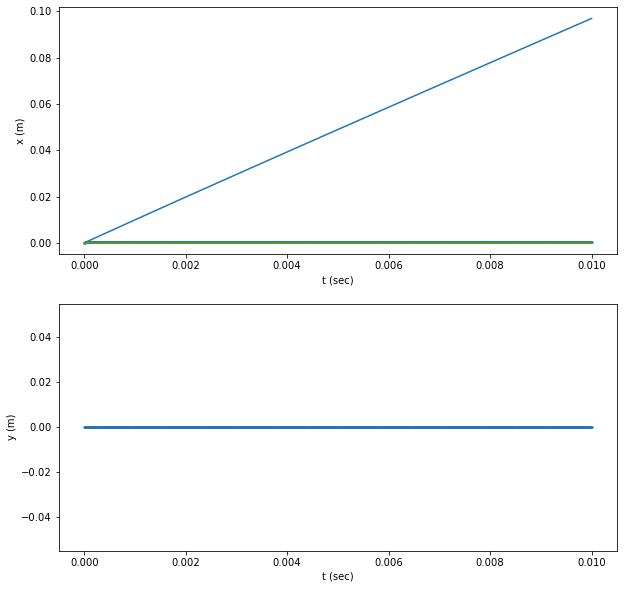

In [200]:
# Timing
num_time = 1000

# Initialize an atom with these velocities
x0 = 10**(-4)
y0 = 0# 10**(-7)
z0 = 0 # -z_len/8 # Release near bottom of cell

vx = 10
vy = 0
vz = 0 #100

vec_x = np.array([x0, y0, z0])
vec_v = np.array([vx, vy, vz])
tt, xx, vv, ff= runEuler_x(vec_x, vec_v, num_timesteps=num_time)

vec_x = np.array([x0, y0, z0])
vec_v = np.array([vx, vy, vz])
smart_t, smart_x = smartEuler(vec_x, vec_v, num_timesteps=num_time)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# positions
ax[0].plot(tt, xx)
ax[0].set_xlabel("t (sec)")
ax[0].set_ylabel("x (m)")

# plot from Smart euler as well
ax[0].scatter(smart_t, smart_x[:,0], label="smartEuler", s=2)

# y plot:
ax[1].scatter(smart_t, smart_x[:,1], label="smartEuler", s=2)
ax[1].set_xlabel("t (sec)")
ax[1].set_ylabel("y (m)")

# velocities
#ax[1].plot(tt, vv)
#ax[1].set_xlabel("t (sec)")
#ax[1].set_ylabel("v (m/s)")

# forces
#ax[2].plot(tt, ff)
#ax[2].set_xlabel("t (sec)")
#ax[2].set_ylabel("F (N)")

Text(0.5, 0, 'z (m)')

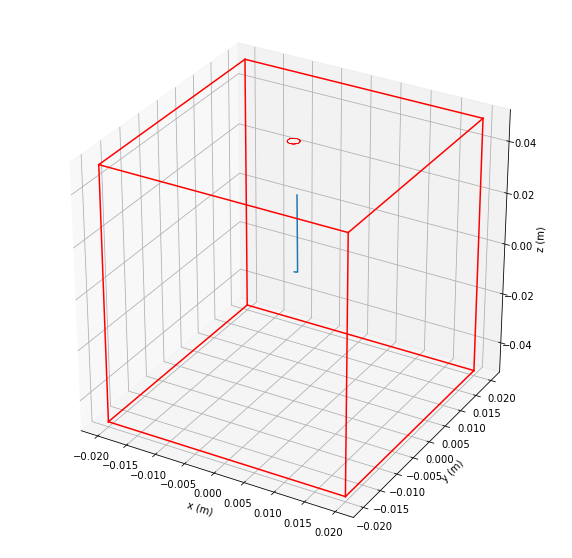

In [220]:
fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(projection='3d')

dt = 10 * 10**(-6)
zs = z0 + vz*dt*np.arange(0, smart_t.shape[0])

ax.plot(smart_x[:, 0], smart_x[:, 1], zs)

# Build cell:
showCell = True
if showCell:
    cell_x = np.linspace(-x_len/2, x_len/2, 1000)
    ax.plot(cell_x, (y_len/2)*np.ones_like(cell_x), (z_len/2)*np.ones_like(cell_x), c="r")
    ax.plot(cell_x, (y_len/2)*np.ones_like(cell_x), -(z_len/2)*np.ones_like(cell_x), c="r")
    ax.plot(cell_x, -(y_len/2)*np.ones_like(cell_x), (z_len/2)*np.ones_like(cell_x), c="r")
    ax.plot(cell_x, -(y_len/2)*np.ones_like(cell_x), -(z_len/2)*np.ones_like(cell_x), c="r")
    cell_y = np.linspace(-y_len/2, y_len/2, 1000)
    ax.plot((x_len/2)*np.ones_like(cell_x), cell_y, (z_len/2)*np.ones_like(cell_x), c="r")
    ax.plot((x_len/2)*np.ones_like(cell_x), cell_y, -(z_len/2)*np.ones_like(cell_x), c="r")
    ax.plot(-(x_len/2)*np.ones_like(cell_x), cell_y, (z_len/2)*np.ones_like(cell_x), c="r")
    ax.plot((-x_len/2)*np.ones_like(cell_x), cell_y, -(z_len/2)*np.ones_like(cell_x), c="r")
    cell_z = np.linspace(-z_len/2, z_len/2, 1000)
    ax.plot((x_len/2)*np.ones_like(cell_x), (y_len/2)*np.ones_like(cell_x), cell_z, c="r")
    ax.plot((x_len/2)*np.ones_like(cell_x), -(y_len/2)*np.ones_like(cell_x), cell_z, c="r")
    ax.plot(-(x_len/2)*np.ones_like(cell_x), (y_len/2)*np.ones_like(cell_x), cell_z, c="r")
    ax.plot((-x_len/2)*np.ones_like(cell_x), -(y_len/2)*np.ones_like(cell_x), cell_z, c="r")

    # Build hole
    uuu = np.linspace(0, 100, 100)
    ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2, c="r", lw=0.1)


ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")

### Proofs

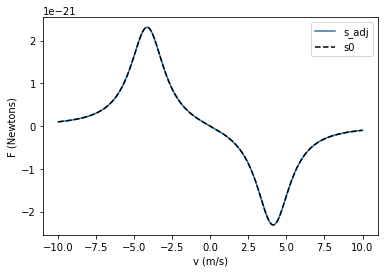

In [230]:
# Proof that radiativeHelper works.
varr = np.linspace(-10**1, 10**1, 1000)
x = 10**(-4)
det = det_x
plus, minus = getDeltaPM(x, varr, det, bgrad_x)

r_sq = (y0)**2 + (z0)**2
s_adj = s0 * np.exp(-2*r_sq/(cooling_waist**2))

plt.plot(varr, radiativeHelper(plus, minus, det, s_adj), label="s_adj")
plt.plot(varr, radiativeHelper(plus, minus, det, s0), label="s0", ls="--", c="k")
plt.xlabel("v (m/s)")
plt.ylabel("F (Newtons)")
plt.legend()

### Random

In [343]:
a = np.array([1,2,3])
a[0] = 2
a

array([2, 2, 3])